(309, 6)
Best Lasso alpha: 3.593813663804626
Best Ridge alpha: 100.0
Improved Lasso Results:
MSE: 6.75074029653008
R2: 0.0
Improved Ridge Results:
MSE: 4.6558727419407635
R2: 0.31031671528914995


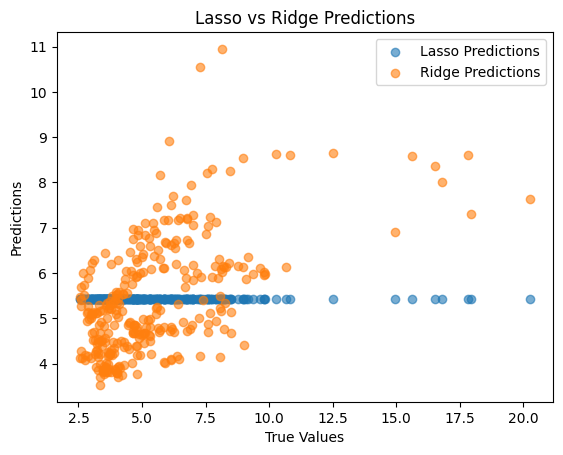

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

# Load the cleaned dataset
data = pd.read_csv("../../data/merged_macroeconomic_credit.csv")

data['Month_End'] = pd.to_datetime(data['Month_End'])
data.set_index('Month_End', inplace=True)

# Preparing features and target
X = data[['Consumer Price Index for All Urban Consumers All Items in U.S. City Average_CPIAUCSL', 
          'Federal Funds Effective Rate _FEDFUNDS', 
          'Industrial Production Total Index_INDPRO', 
          'Leading Indicators OECD Reference Series Gross Domestic Product (GDP) Original Series for the Euro Area (19 Countries)EA19LORSGPORGYSAM', 
          'Unemployment Rate_UNRATE', 
          'University of Michigan Consumer Sentiment_UMCSENT']]
y = data['BAMLH0A0HYM2']
X = X.dropna()
y = y[X.index]
print(X.shape)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality 
pca = PCA(n_components=3)  # Chosing 3 
X_pca = pca.fit_transform(X_scaled)

# TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# HP tuning for Lasso
lasso_params = {'alpha': np.logspace(-3, 1, 10)}  
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=tscv, scoring='neg_mean_squared_error')
lasso_cv.fit(X_pca, y)  

# HP tuning for Ridge with adjusted alpha range
ridge_params = {'alpha': np.logspace(-3, 2, 10)}  
ridge_cv = GridSearchCV(Ridge(max_iter=30000), ridge_params, cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(X_pca, y) 

print("Best Lasso alpha:", lasso_cv.best_params_['alpha'])
print("Best Ridge alpha:", ridge_cv.best_params_['alpha'])
y_pred_lasso = lasso_cv.best_estimator_.predict(X_pca)
y_pred_ridge = ridge_cv.best_estimator_.predict(X_pca)

#Metrics
print("Improved Lasso Results:")
print(f"MSE: {mean_squared_error(y, y_pred_lasso)}")
print(f"R2: {r2_score(y, y_pred_lasso)}")
print("Improved Ridge Results:")
print(f"MSE: {mean_squared_error(y, y_pred_ridge)}")
print(f"R2: {r2_score(y, y_pred_ridge)}")

# Plots
import matplotlib.pyplot as plt

plt.scatter(y, y_pred_lasso, label="Lasso Predictions", alpha=0.6)
plt.scatter(y, y_pred_ridge, label="Ridge Predictions", alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Lasso vs Ridge Predictions')
plt.legend()
plt.show()


^regression pipeline- lasso, ridge implemented. Scaled, reduced by PCA, optimal parameter values loaded, inflated alpha. TSSplit for cross-validation. HP tuning using GridSearchCV. Lasso continues to give poor results.

In [28]:
correlation_matrix = data[['Consumer Price Index for All Urban Consumers All Items in U.S. City Average_CPIAUCSL', 
                            'Federal Funds Effective Rate _FEDFUNDS', 'Unemployment Rate_UNRATE', 
                            'BAMLH0A0HYM2']].corr()
print(correlation_matrix)

                                                    Consumer Price Index for All Urban Consumers All Items in U.S. City Average_CPIAUCSL  \
Consumer Price Index for All Urban Consumers Al...                                           1.000000                                      
Federal Funds Effective Rate _FEDFUNDS                                                      -0.686326                                      
Unemployment Rate_UNRATE                                                                     0.114233                                      
BAMLH0A0HYM2                                                                                -0.126391                                      

                                                    Federal Funds Effective Rate _FEDFUNDS  \
Consumer Price Index for All Urban Consumers Al...                               -0.686326   
Federal Funds Effective Rate _FEDFUNDS                                            1.000000   
Unemployment Rate

Best Lasso alpha: 0.46415888336127775
Best Ridge alpha: 100.0
Improved Lasso Results:
MSE: 4.6579
R2: 0.3100
Improved Ridge Results:
MSE: 3.9284
R2: 0.4181

Feature importance (Lasso):
University of Michigan Consumer Sentiment_UMCSENT                                                                                          0.559286
Leading Indicators OECD Reference Series Gross Domestic Product (GDP) Original Series for the Euro Area (19 Countries)EA19LORSGPORGYSAM    0.487961
Industrial Production Total Index_INDPRO                                                                                                   0.318428
Consumer Price Index for All Urban Consumers All Items in U.S. City Average_CPIAUCSL                                                       0.000000
Federal Funds Effective Rate _FEDFUNDS                                                                                                     0.000000
Unemployment Rate_UNRATE                                                   

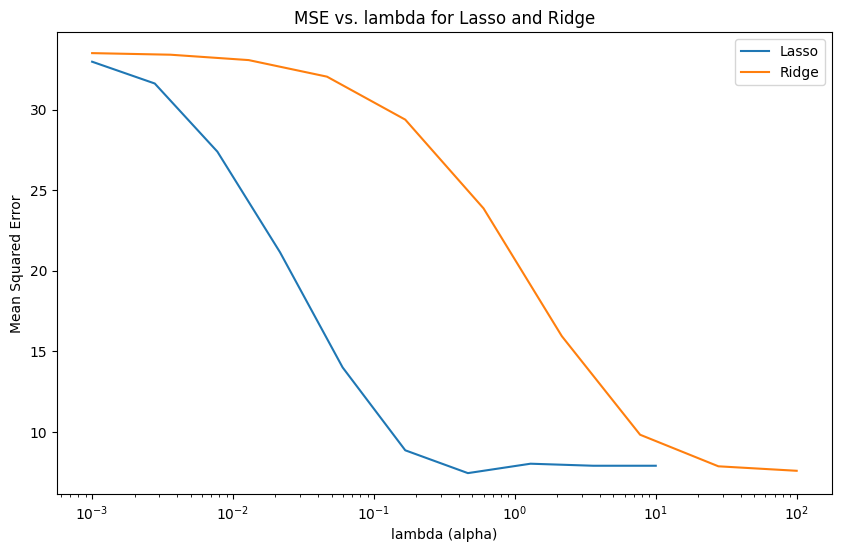

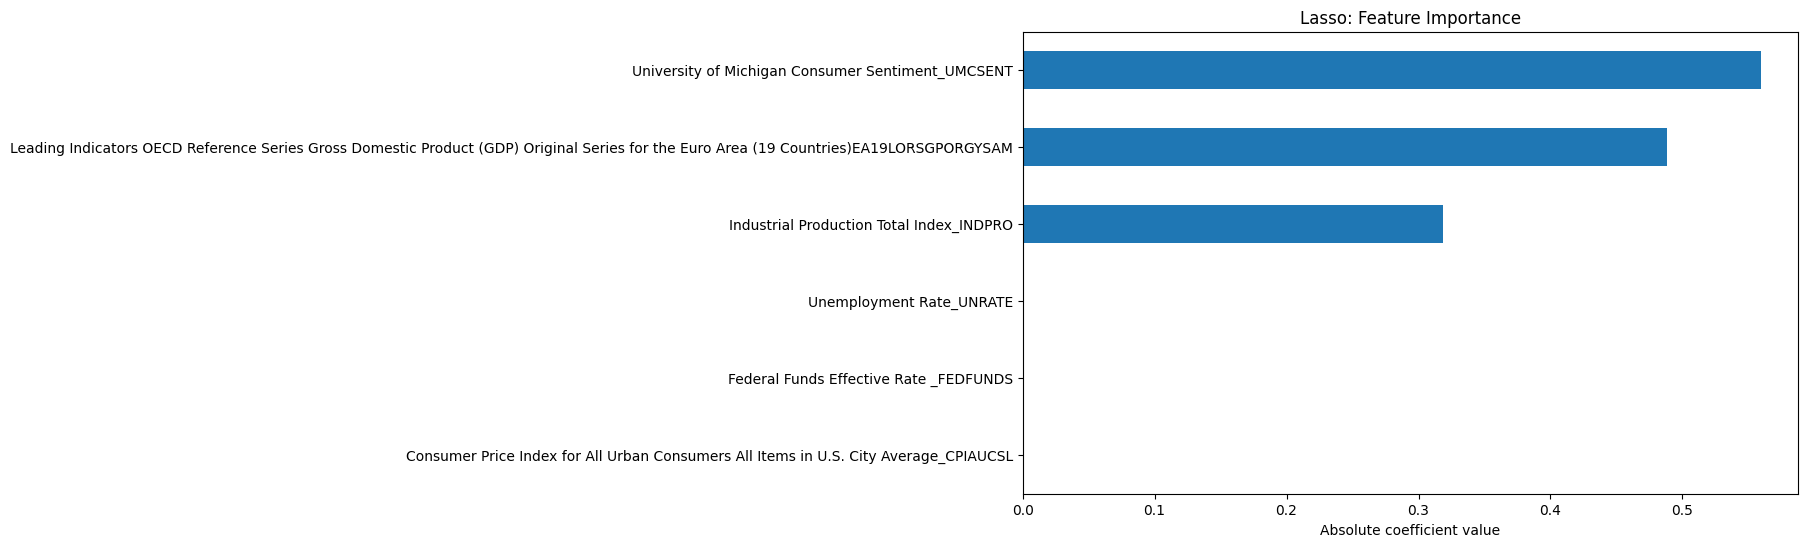

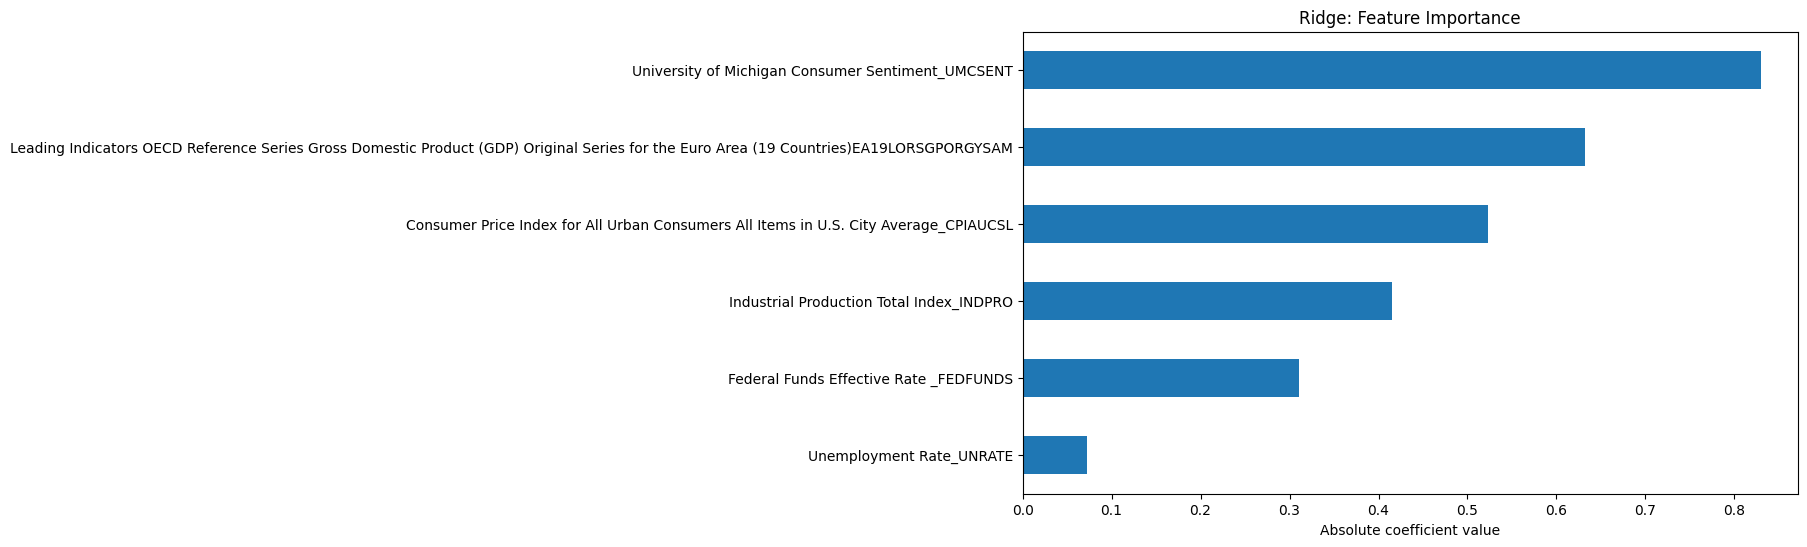

<Figure size 640x480 with 0 Axes>

In [ ]:

# HP tuning Lasso
lasso_params = {'alpha': np.logspace(-3, 1, 10)}  
lasso_cv = GridSearchCV(Lasso(max_iter=30000), lasso_params, cv=tscv, scoring='neg_mean_squared_error')  # increased iterations
lasso_cv.fit(X_scaled, y)

# HP tuning Ridge
ridge_params = {'alpha': np.logspace(-3, 2, 10)}
ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y)

print("Best Lasso alpha:", lasso_cv.best_params_['alpha'])
print("Best Ridge alpha:", ridge_cv.best_params_['alpha'])
y_pred_lasso = lasso_cv.best_estimator_.predict(X_scaled)
y_pred_ridge = ridge_cv.best_estimator_.predict(X_scaled)

print("Improved Lasso Results:")
print(f"MSE: {mean_squared_error(y, y_pred_lasso):.4f}")
print(f"R2: {r2_score(y, y_pred_lasso):.4f}")
print("Improved Ridge Results:")
print(f"MSE: {mean_squared_error(y, y_pred_ridge):.4f}")
print(f"R2: {r2_score(y, y_pred_ridge):.4f}")

# Feature importance for Lasso and Ridge
lasso_coef = pd.Series(lasso_cv.best_estimator_.coef_, index=X.columns)
print("\nFeature importance (Lasso):")
print(lasso_coef.abs().sort_values(ascending=False))
ridge_coef = pd.Series(ridge_cv.best_estimator_.coef_, index=X.columns)
print("\nFeature importance (Ridge):")
print(ridge_coef.abs().sort_values(ascending=False))

#  Plots
#  MSE vs. lambda 
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_cv.cv_results_['param_alpha'], -lasso_cv.cv_results_['mean_test_score'], label='Lasso')
plt.semilogx(ridge_cv.cv_results_['param_alpha'], -ridge_cv.cv_results_['mean_test_score'], label='Ridge')
plt.xlabel('lambda (alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. lambda for Lasso and Ridge')
plt.legend()
plt.show()

#  Bar plots of feature importance

def plot_feature_importance(coef, title):
    plt.figure(figsize=(10, 6))
    coef.abs().sort_values(ascending=True).plot.barh()
    plt.xlabel('Absolute coefficient value')
    plt.title(title)
    plt.show()
plot_feature_importance(lasso_coef, 'Lasso: Feature Importance')
plot_feature_importance(ridge_coef, 'Ridge: Feature Importance')



Lasso and Ridge without PCA. Plota- feature importance, MSE vs lambda

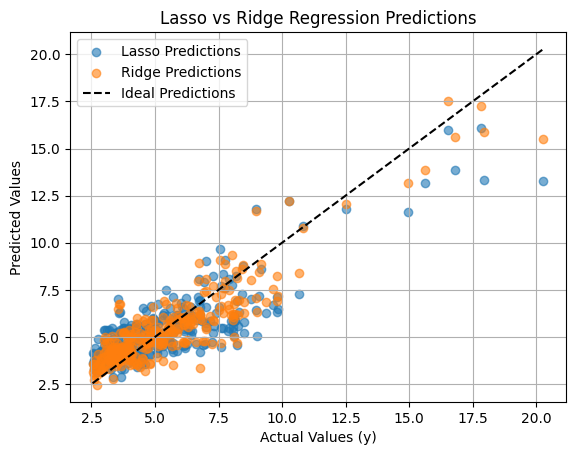

In [10]:
plt.scatter(y, y_pred_lasso, label="Lasso Predictions", alpha=0.6) 
plt.scatter(y, y_pred_ridge, label="Ridge Predictions", alpha=0.6)
min_val, max_val = min(y), max(y)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label="Ideal Predictions")
plt.xlabel("Actual Values (y)")
plt.ylabel("Predicted Values")
plt.title("Lasso vs Ridge Regression Predictions")
plt.legend()
plt.grid(True)

plt.show()